### lighteval is your AI evaluation library

This notebook explores how you can use lighteval to evaluate and compare LLMs.

`lighteval` has been around a while and it's a great tool for getting eval score on major benchmarks. It's just been refactored to support being used like a library in Python, which makes it great for comparing models across benchmarks.

So let's dig in to some eval scores.

### Exercise: Evaluate Your Own Model

Now that you've seen how to evaluate models on specific domains, try evaluating a model on a domain that interests you.

Difficulty Levels

🐢 Use the existing medical domain tasks but evaluate a different model from the Hugging Face hub

🐕 Create a new domain evaluation by selecting different MMLU tasks (e.g., computer science, mathematics, physics)

🦁 Create a custom evaluation task using LightEval's task framework and evaluate models on your specific domain



```python
# !pip install -qqq -U "torch<2.5" "torchvision<2.5" "torchaudio<2.5" --index-url https://download.pytorch.org/whl/cu121
# !pip list | grep torch
# Install package directly from a GitHub repository instead of PyPI (Not affect to installed dependencies)
!pip install -qqq git+https://github.com/huggingface/lighteval.git tiktoken
!pip install lighteval[math]
```

In [1]:
#!pip install lighteval
!pip show lighteval

Name: lighteval
Version: 0.6.0.dev0
Summary: A lightweight and configurable evaluation package
Home-page: https://github.com/huggingface/lighteval
Author: 
Author-email: Clémentine Fourrier <clementine@huggingface.com>, Nathan Habib <nathan.habib@huggingface.com>, Thomas Wolf <thom@huggingface.com>
License: MIT License
Location: /home/loc/miniconda3/envs/py3x/lib/python3.10/site-packages
Requires: accelerate, aenum, colorlog, datasets, fsspec, GitPython, huggingface_hub, nltk, numpy, protobuf, pycountry, pytablewriter, rich, rouge_score, sacrebleu, scikit-learn, sentencepiece, termcolor, torch, transformers, typer
Required-by: 


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
Tesla P40


### Setup lighteval evaluation

We need to setup the evaluation environment and pipeline. Much of this we will disable because we're keeping things in the notebook, but we could also use `push_to_hub` or `push_to_tensorboard`.

**`push_to_hub`**

This is useful if we're evaluating a model and want to persist its evaluation with weights and configuration on the Hugging Face hub.

**`push_to_tensorboard`**

This would be useful if we were building an evaluation tool or script, where we wanted to view results within tensorboard.

In [6]:
import lighteval
from datetime import timedelta
from transformers import AutoModelForCausalLM

from lighteval.logging.evaluation_tracker import EvaluationTracker
# from lighteval.logging.hierarchical_logger import hlog_warn, htrack
#from lighteval.models.model_config import create_model_config
from lighteval.pipeline import EnvConfig, ParallelismManager, Pipeline, PipelineParameters


with open("/home/loc/Documents/keys/HF_key.txt") as f:
    TOKEN = f.read().strip()


In [8]:

env_config = EnvConfig(token=TOKEN, cache_dir="~/tmp")

evaluation_tracker = EvaluationTracker(
    output_dir="~/tmp",
    save_details=False,
    push_to_hub=False,
    push_to_tensorboard=False,
    public=False,
    hub_results_org=False,
)

pipeline_params = PipelineParameters(
    launcher_type=ParallelismManager.ACCELERATE,
    env_config=env_config,
    job_id=1,
    override_batch_size=1,
    num_fewshot_seeds=0,
    max_samples=10,
    use_chat_template=False,
)

### Compares models with `lighteval`

We are going to compare two small LLMs on a domain. We will use `Qwen2.5-0.5B` and `SmolLM2-360M-Instruct` and we will evaluate them on a medical domain.

We can create a domain evaluation from a subset of MMLU evaluations, by defining the evaluation tasks. In lighteval, tasks are described as strings.

```
{suite}|{task}:{subtask}|{num_few_shot}|{0 or 1 to reduce num_few_shot if prompt is too long}
```

Therefore, we will pass our list of medicine related tasks like this:

```
leaderboard|mmlu:anatomy|5|0,leaderboard|mmlu:professional_medicine|5|0,leaderboard|mmlu:high_school_biology|5|0,leaderboard|mmlu:high_school_chemistry|5|0
```

Which can be translated to :

| Suite       | Task                             | Num Fewshot Example | Limit Fewshots |
|------------|---------------------------------|---------------------|---------------|
| leaderboard | mmlu:anatomy                   | 5                   | False         |
| leaderboard | mmlu:professional_medicine     | 5                   | False         |
| leaderboard | mmlu:high_school_biology       | 5                   | False         |
| leaderboard | mmlu:high_school_chemistry     | 5                   |               |


For a full list of lighteval supported tasks. Checkout this page in [the documentation](https://github.com/huggingface/lighteval/wiki/Available-Tasks).

In [9]:
domain_tasks = "leaderboard|mmlu:anatomy|5|0,leaderboard|mmlu:professional_medicine|5|0,leaderboard|mmlu:high_school_biology|5|0,leaderboard|mmlu:high_school_chemistry|5|0"

### Evaluate Qwen2.5 0.5B

In [10]:
qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=qwen_model
)

pipeline.evaluate()

qwen_results = pipeline.get_results()
     

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

--max_samples WAS SET. THESE NUMBERS ARE ONLY PARTIAL AND SHOULD NOT BE USED FOR COMPARISON UNLESS YOU KNOW WHAT YOU ARE DOING.


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

Problem when loading the tokenizer in the cache - discarding the provided cache path value.


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

If you want to use extended_tasks, make sure you installed their dependencies using `pip install -e .[extended_tasks]`.


README.md:   0%|          | 0.00/39.7k [00:00<?, ?B/s]

mmlu.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/310 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/8.31k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/203 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/8.45k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/272 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (334 > 20). Running this sequence through the model will result in indexing errors
0it [00:00, ?it/s]
%|                                                                       | 0/40 [00:00<?, ?it/s]
%|█▌                                                             | 1/40 [00:00<00:08,  4.86it/s]
%|████████████▌                                                  | 8/40 [00:00<00:01, 30.25it/s]
%|███████████████████████▎                                      | 15/40 [00:00<00:00, 43.63it/s]
%|██████████████████████████████████                            | 22/40 [00:00<00:00, 51.65it/s]
%|████████████████████████████████████████████▉                 | 29/40 [00:00<00:00, 56.93it/s]
100%|██████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.50it/s]
1it [00:00,  1.26it/s]
%|                                                                       | 0/40 [00:00<?, ?it/s

In [12]:
pipeline.show_results()

|                  Task                  |Version|Metric|Value|   |Stderr|
|----------------------------------------|------:|------|----:|---|-----:|
|all                                     |       |acc   |  0.3|±  |0.1408|
|leaderboard:mmlu:_average:5             |       |acc   |  0.3|±  |0.1408|
|leaderboard:mmlu:anatomy:5              |      0|acc   |  0.5|±  |0.1667|
|leaderboard:mmlu:high_school_biology:5  |      0|acc   |  0.1|±  |0.1000|
|leaderboard:mmlu:high_school_chemistry:5|      0|acc   |  0.2|±  |0.1333|
|leaderboard:mmlu:professional_medicine:5|      0|acc   |  0.4|±  |0.1633|



### Evaluate SmolLM 360M

In [13]:

smol_model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-360M-Instruct")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=smol_model
)

pipeline.evaluate()

--max_samples WAS SET. THESE NUMBERS ARE ONLY PARTIAL AND SHOULD NOT BE USED FOR COMPARISON UNLESS YOU KNOW WHAT YOU ARE DOING.


tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

Problem when loading the tokenizer in the cache - discarding the provided cache path value.
If you want to use extended_tasks, make sure you installed their dependencies using `pip install -e .[extended_tasks]`.
Token indices sequence length is longer than the specified maximum sequence length for this model (341 > 20). Running this sequence through the model will result in indexing errors
0it [00:00, ?it/s]
%|                                                                       | 0/40 [00:00<?, ?it/s]
%|███████▉                                                       | 5/40 [00:00<00:00, 40.93it/s]
%|███████████████▌                                              | 10/40 [00:00<00:00, 40.30it/s]
%|██████████████████████████▎                                   | 17/40 [00:00<00:00, 46.09it/s]
%|██████████████████████████████████                            | 22/40 [00:00<00:00, 42.19it/s]
%|████████████████████████████████████████████▉                 | 29/40 [00:00<00:00, 50.42it/s]
100%|█

In [14]:
smol_results = pipeline.get_results()

In [15]:
pipeline.show_results()

|                  Task                  |Version|Metric|Value |   |Stderr|
|----------------------------------------|------:|------|-----:|---|-----:|
|all                                     |       |acc   |0.3333|±  |0.1169|
|leaderboard:mmlu:_average:5             |       |acc   |0.3400|±  |0.1121|
|leaderboard:mmlu:anatomy:5              |      0|acc   |0.4500|±  |0.1141|
|leaderboard:mmlu:high_school_biology:5  |      0|acc   |0.1500|±  |0.0819|
|leaderboard:mmlu:high_school_chemistry:5|      0|acc   |0.3500|±  |0.1094|
|leaderboard:mmlu:professional_medicine:5|      0|acc   |0.4500|±  |0.1141|



### Visualize Results

Now that we have results from the two models we can visualize them side-by-side. We'll keep visualisation simple here, but with this data structure you could represent scores in many ways.

<Axes: >

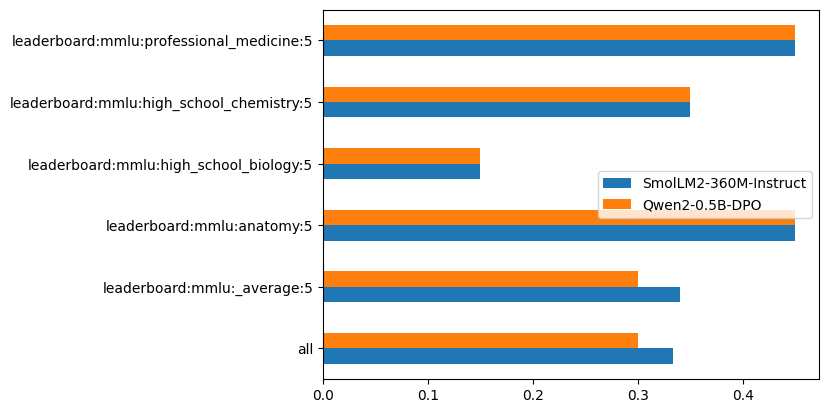

In [18]:
import pandas as pd

df = pd.DataFrame.from_records(smol_results["results"]).T["acc"].rename("SmolLM2-360M-Instruct")
_df = pd.DataFrame.from_records(qwen_results["results"]).T["acc"].rename("Qwen2-0.5B-DPO")
df = pd.concat([df, _df], axis=1)
df.plot(kind="barh")

### 💐 That's it!

You have a handy notebook to view model evals. You could use this to:

- select the right model for your inference use case
- evaluate checkpoints during training
- share model scores

🏃Next Steps

If you want to go deeper into your evaluation results check out this notebook

